## Revtsov HW4

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

idx = pd.IndexSlice

from sklearn.linear_model import LinearRegression

### Problem 1

In [2]:
# set start/end dates
sd = '2008-11-01'
ed = '2020-04-01'

# create frame of portfolio wts
wts = pd.DataFrame(
    index=['XLF', 'XLB', 'XLI', 'XLY', 'XLK', 'XLE', 'XLV', 'XLP', 'XLU'],
    data=[
        [0.12, 0.05, 0.16], 
        [0.11, 0.1, 0.14], 
        [0.11, 0.1, 0.13], 
        [0.11, 0.15, 0.12], 
        [0.11, 0.2, 0.11], 
        [0.11, 0.15, 0.1], 
        [0.11, 0.10, 0.09], 
        [0.11, 0.1, 0.08], 
        [0.11, 0.05, 0.07]],
    columns=['Port1', 'Port2', 'Port3'],
)
wts.index.name = 'Ticker'

# create frame of scenarios
scenarios = pd.DataFrame(
    index=['GFC', 'Mkt Sell Off', 'Covid Lockdown'],
    data=[['2008-09-16', '2009-03-09'], ['2015-08-18', '2015-08-21'], ['2020-02-19', '2020-03-23']],
    columns=['Start', 'End']
)
scenarios.index.name = 'Name'
scenarios.Start = pd.to_datetime(scenarios.Start)
scenarios.End = pd.to_datetime(scenarios.End)

In [3]:
# retrieve data, calculate the daily returns
df = yf.download(wts.index.tolist(), start=sd, end=ed)
px = df.loc[:, idx['Adj Close']]
rts = px.pct_change().dropna(axis=0)

[*********************100%%**********************]  9 of 9 completed


In [4]:
# calculate the returns for portfolios
# this is assuming daily rebalancing
rts_p = np.matmul(rts, wts.values)
rts_p.columns = wts.columns

In [5]:
# for each scenario, calculate the cumulative performance of the portfolios
# join onto the original scenarios frame
scenarios = scenarios.join(scenarios.apply(lambda x: rts_p.loc[x.Start:x.End].add(1).prod().add(-1), axis=1))

#### Returns of portfolios for each scenario are below 

In [6]:
scenarios

,Start,End,Port1,Port2,Port3
Name,,,,,
GFC,2008-09-16,2009-03-09,-0.284804,-0.277786,-0.296779
Mkt Sell Off,2015-08-18,2015-08-21,-0.058752,-0.059507,-0.060684
Covid Lockdown,2020-02-19,2020-03-23,-0.366746,-0.359385,-0.379775


### Problem 2

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred

# FRED API Key
fred_api_key = "a4223ad593cd95d79d4699851ddfe0b4"

# Define FRED objects
fred = Fred(api_key=fred_api_key)

# Download data
cpi = fred.get_series("FPCPITOTLZGUSA")  # CPI Inflation
recessions = fred.get_series("JHDUSRGDPBR")  # US Recessions (indicator)

In [8]:
# Combine data into DataFrame
data = cpi.rename('CPI').to_frame().join(recessions.rename('Recession'))
data.index.name = 'Year'

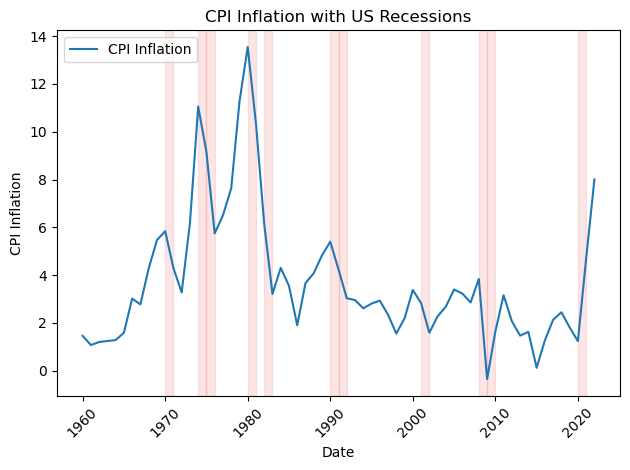

In [9]:
# Define recession periods (assuming value of 1 indicates recession)
recession_periods = data[data['Recession'] == 1].index

# Create plot
fig, ax = plt.subplots()
ax.plot(data['CPI'], label='CPI Inflation')

# Shade recession areas
for recession in recession_periods:
    # Shade a year after recession start
    ax.axvspan(recession, recession + pd.Timedelta(days=365), color='lightcoral', alpha=0.2, zorder=0)  

ax.set_xlabel('Date')
ax.set_ylabel('CPI Inflation')
ax.set_title('CPI Inflation with US Recessions')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Problem 3

In [10]:
def jensen_alpha(mu, rfr, beta, mu_mkt):
    return mu - (beta * mu_mkt + (1+beta) * rfr)

In [11]:
fund_rts = pd.read_csv('HW43DATA.csv')
fund_rts.date = pd.to_datetime(fund_rts.date).dt.date
fund_rts = fund_rts.rename(columns={'date': 'Date'}).set_index('Date')

In [12]:
factor_rts = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')
factor_rts.Date = pd.to_datetime(factor_rts.Date, format='%Y%m').dt.date
factor_rts = factor_rts.set_index('Date')
factor_rts = factor_rts.loc[fund_rts.index.min():fund_rts.index.max()]
factor_rts /= 100

In [13]:
regr_res = pd.DataFrame(index=fund_rts.columns, columns=factor_rts.drop(columns=['RF']).columns)

for etf in regr_res.index:
    # dependent variables are the factor returns
    X = factor_rts.drop(columns=['RF'])
    # independent variable is the excess etf return (excess of risk free rate)
    y = fund_rts[etf] - factor_rts.RF

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get coefficients
    regr_res.loc[etf, :] = model.coef_

#### Coefficients

In [14]:
# SMB: small minus big (size)
# HML: high minus low (value)
# RMW: robust minus weak (profitability)
# CMA: cons minus agg
regr_res.round(2)

,Mkt-RF,SMB,HML,RMW,CMA
Fund 1,1.02633,0.815425,-0.160409,-0.217254,-0.109885
Fund 2,1.006263,0.227612,0.131227,0.023022,-0.068062
Fund 3,0.982413,-0.122338,0.02974,0.063997,0.016008
Fund 4,0.941388,1.064754,0.118316,-0.2654,0.004922


#### Fund Types

- fund 1: small cap
- fund 2: mid cap value
- fund 3: large cap
- fund 4: small cap, maybe value due to loadings on HML

#### Jensen Alpha

In [15]:
mu_mkt = (factor_rts['Mkt-RF'] + factor_rts['RF']).mean()
rfr = factor_rts['RF'].mean()

In [16]:
fund_ja = pd.Series(index=fund_rts.columns, name='Jensen Alpha', dtype=float)
for fund in fund_ja.index:
    mu = fund_rts[fund].mean()
    beta = regr_res.loc[fund, 'Mkt-RF']
    fund_ja.loc[fund] = jensen_alpha(mu, rfr, beta, mu_mkt)
fund_ja

Fund 1   -0.005283
Fund 2   -0.004028
Fund 3   -0.002121
Fund 4   -0.005337
Name: Jensen Alpha, dtype: float64